# R data

In [1]:
u1_csv=r'..\data\haptic_data\flexible-haptic\user1_flexible-haptic_2025-03-27T16-04-54_112135.csv'
u2_csv=r'..\data\haptic_data\flexible-haptic\user3_flexible-haptic_2025-03-27T16-10-40_456602.csv'
u3_csv=r'..\data\haptic_data\flexible-haptic\user3_flexible-haptic_2025-03-27T16-45-29_971081.csv'
u4_csv=r'..\data\haptic_data\flexible-haptic\user4_flexible-haptic_2025-03-27T16-57-32_536460.csv'

u1_wav=r'../data/haptic_data/flexible-haptic/user1_flexible-haptic_2025-03-27T16-04-54_112135.wav'
u2_wav=r'../data/haptic_data/flexible-haptic/user3_flexible-haptic_2025-03-27T16-10-40_456602.wav'
u3_wav=r'../data/haptic_data/flexible-haptic/user3_flexible-haptic_2025-03-27T16-45-29_971081.wav'
u4_wav=r'../data/haptic_data/flexible-haptic/user4_flexible-haptic_2025-03-27T16-57-32_536460.wav'

# Pre data

# datastruct

- *audio_haptic # 200ms  150 play +50 buffer
- audio_haptic_spec 
- *audio_press  # 60 ms 
- audio_press_spec
- audio_press_mfcc
- *Inertial_press  # 60  fixed stgart  point 
- *Inertial_haptic  # 40   dynamic start point
- *Inertial_whole # can overlap 150 ?
- Audio_whole  # can overlap   300ms? 


- Rule
- Find the highest power 150ms, and extend to the left + 50ms , which is 200ms for the 
    - audio_haptic
    - Mark the start time  T1
- Find the left start from T1 boundary of the none,none,none,none,cross,cross,cross 
    - Mark the start time T2 
    - Based on the T2 at CSV go to left + 10 records ,mark the time T3
- From T3 go to right +60 records mark the inertial_press data( 60 records)
    - Inertial _press

- From T1 find the csv time +60 records 
    - inertial_haptic

- From T3 +150 records
    - Inertial_whole

- From T3 + 200 ms and then within 200ms find the average highest power 60ms 
    - Audio_press

- From T3 - end of the audio_haptic 
    - Audio_whole

ineritl_press 
inertial_press + press mfcc
inertial_press + hatpcic spec
inertial_whole + press mfcc + hatpci spec

In [2]:
import os
import re
import numpy as np
import librosa
import pandas as pd
from scipy.signal import find_peaks
from datetime import datetime, timedelta

def extract_start_timestamp_from_filename(filename):
    match = re.search(r'\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}', filename)
    if match:
        timestamp = match.group(0)
        parts = timestamp.split('T')
        if len(parts) == 2:
            date_part = parts[0]
            time_part = parts[1].replace('-', ':')
            return f"{date_part}T{time_part}"
    return None

def prepare_audio_csv_segement(wav_path, csv_path, n_segments=100, segment_duration=0.15, pre_segment_duration=0.05):
    audio, sr = librosa.load(wav_path, sr=None)
    segment_length = int(segment_duration * sr)
    pre_segment_length = int(pre_segment_duration * sr)
    total_length = segment_length + pre_segment_length
    hop_length = segment_length // 4

    energy = librosa.feature.rms(y=audio, frame_length=segment_length, hop_length=hop_length, center=True)[0]
    peaks, _ = find_peaks(energy, distance=segment_length / hop_length)

    if len(peaks) < n_segments:
        additional = np.linspace(0, len(energy) - 1, n_segments - len(peaks), dtype=int)
        peaks = np.concatenate([peaks, additional])

    peak_samples = peaks * hop_length
    energies = []
    valid_pos = []

    for pos in peak_samples:
        if pos + segment_length <= len(audio):
            segment = audio[pos:pos + segment_length]
            energies.append(np.mean(np.abs(segment)))
            valid_pos.append(pos)

    sorted_idx = np.argsort(energies)[::-1]
    audio_haptic = []
    selected_positions = []
    energy_values = []
    used_ranges = []
    haptic_segment_timestamps = []
    inertial_haptic = []

    file_start_timestamp = extract_start_timestamp_from_filename(os.path.basename(wav_path))

    # Read the CSV and prepare timestamps
    df = pd.read_csv(csv_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    for idx in sorted_idx:
        pos = valid_pos[idx]
        start = max(0, pos - pre_segment_length)
        end = pos + segment_length

        if any(not (end <= u_start or start >= u_end) for u_start, u_end in used_ranges):
            continue

        haptic_segment = audio[start:end]
        if len(haptic_segment) < total_length:
            haptic_segment = np.pad(haptic_segment, (0, total_length - len(haptic_segment)))

        haptic_segment_start_time_sec = start / sr

        if file_start_timestamp:
            try:
                file_datetime = datetime.fromisoformat(file_start_timestamp)
                haptic_segment_datetime = file_datetime + timedelta(seconds=haptic_segment_start_time_sec)
                haptic_segment_timestamp = haptic_segment_datetime.isoformat()
            except ValueError:
                haptic_segment_timestamp = f"{haptic_segment_start_time_sec:.6f}"
        else:
            haptic_segment_timestamp = f"{haptic_segment_start_time_sec:.6f}"

        audio_haptic.append(haptic_segment)
        energy_values.append(energies[idx])
        selected_positions.append((start, end))
        used_ranges.append((start, end))
        haptic_segment_timestamps.append(haptic_segment_timestamp)

        # Match with CSV data
        try:
            target_time = pd.to_datetime(haptic_segment_timestamp)
            closest_idx = (df['timestamp'] - target_time).abs().idxmin()+40 # delay the 40 records find the data
            end_idx = min(closest_idx + 40, len(df))  # 200ms is 40 records 
            inertial_sample = df.iloc[closest_idx:end_idx].to_dict(orient='records')
            inertial_haptic.append(inertial_sample)
        except Exception as e:
            inertial_haptic.append([])

        if len(audio_haptic) >= n_segments:
            break

    return {
        'audio_haptic': audio_haptic, # 200ms for each segment
        'hap_timestamp': haptic_segment_timestamps, # start time of the audio_haptic
        'energy_values': energy_values,
        'sampling_rate': sr,
        'file_start_timestamp': file_start_timestamp,
        'selected_positions': selected_positions,
        'full_audio': audio,
        'inertial_haptic': inertial_haptic # align with the audio haptic 60 records 
    }


In [3]:
import matplotlib.pyplot as plt
import librosa.display

def plot_audio_haptic_segments(audio_haptic_data, max_plots=10):
    """
    Plot waveform and spectrogram of each audio_haptic segment.

    Args:
        audio_haptic_data (dict): Output from find_high_amplitude_segments_simple
        max_plots (int): Max number of segments to plot
    """
    audio_haptic = audio_haptic_data['audio_haptic']
    sr = audio_haptic_data['sampling_rate']
    energy_values = audio_haptic_data['energy_values']

    n_segments = len(audio_haptic)
    max_plots = min(max_plots or n_segments, n_segments)

    segments_per_row = 5
    n_rows = (max_plots + segments_per_row - 1) // segments_per_row

    fig, axs = plt.subplots(n_rows * 2, segments_per_row, figsize=(20, 6 * n_rows))

    for i in range(max_plots):
        row_waveform = (i // segments_per_row) * 2
        col = i % segments_per_row

        # Plot waveform
        axs[row_waveform, col].plot(audio_haptic[i], color='gray')
        axs[row_waveform, col].set_title(f"Waveform {i+1} (Energy: {energy_values[i]:.4f})")
        axs[row_waveform, col].set_xlabel("Samples")
        axs[row_waveform, col].set_ylabel("Amplitude")

        # Plot spectrogram
        S = librosa.stft(audio_haptic[i])
        D = librosa.amplitude_to_db(np.abs(S), ref=np.max)
        img = librosa.display.specshow(D, sr=sr, y_axis='log', x_axis='time', ax=axs[row_waveform + 1, col])
        axs[row_waveform + 1, col].set_title(f"Spectrogram {i+1}")
        fig.colorbar(img, ax=axs[row_waveform + 1, col], format="%+2.0f dB")

    # Hide unused subplots
    for i in range(max_plots, n_rows * segments_per_row):
        row_waveform = (i // segments_per_row) * 2
        col = i % segments_per_row
        axs[row_waveform, col].axis('off')
        axs[row_waveform + 1, col].axis('off')

    plt.tight_layout()
    plt.show()

def plot_full_audio_with_segments(audio_haptic_data):
    """
    Plot the full audio waveform with highlighted segments.
    
    Args:
        audio_haptic_data (dict): Output from prepare_audio_csv_segement
    """
    full_audio = audio_haptic_data['full_audio']
    sr = audio_haptic_data['sampling_rate']
    selected_positions = audio_haptic_data['selected_positions']
    energy_values = audio_haptic_data['energy_values']
    
    # Create time axis in seconds
    time = np.arange(len(full_audio)) / sr
    
    plt.figure(figsize=(20, 6))
    plt.plot(time, full_audio, color='gray', alpha=0.7)
    
    # Highlight each selected segment with a different color
    colors = plt.cm.rainbow(np.linspace(0, 1, len(selected_positions)))
    
    for i, ((start, end), color, energy) in enumerate(zip(selected_positions, colors, energy_values)):
        start_time = start / sr
        end_time = end / sr
        segment_time = np.arange(start, end) / sr
        segment_audio = full_audio[start:end]
        
        plt.plot(segment_time, segment_audio, color=color, linewidth=2)
        
        # Add vertical lines to mark segment boundaries
        plt.axvline(x=start_time, color=color, linestyle='--', alpha=0.7)
        plt.axvline(x=end_time, color=color, linestyle='--', alpha=0.7)
        
        # Add segment index and energy directly on the waveform
        mid_time = (start_time + end_time) / 2
        max_amp = np.max(segment_audio)
        plt.text(mid_time, max_amp, f"{i+1}\nE:{energy:.2f}", 
                 color=color, fontweight='bold', ha='center', va='bottom')
        
        # Add color range indicator
        plt.axhspan(min(segment_audio), max(segment_audio), 
                   xmin=(start_time/time[-1]), xmax=(end_time/time[-1]), 
                   color=color, alpha=0.1)
    
    plt.title('Full Audio Waveform with Highlighted Haptic Segments')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()



def plot_inertial_haptic_sequences_grid(result, max_plots=10):
    inertial_haptic = result.get('inertial_haptic', [])
    timestamps = result.get('hap_timestamp', [])
    
    gyro_fields = ['gyro_pitch', 'gyro_yaw', 'gyro_roll']
    acc_fields = ['acc_x', 'acc_y', 'acc_z']
    
    num_to_plot = min(max_plots, len(inertial_haptic))
    
    fig, axes = plt.subplots(num_to_plot, 2, figsize=(14, 3 * num_to_plot), squeeze=False)
    fig.suptitle("Inertial Haptic Segments", fontsize=16)
    
    for i in range(num_to_plot):
        sequence = inertial_haptic[i]
        if not sequence or not all(field in sequence[0] for field in gyro_fields + acc_fields):
            print(f"Skipping sequence {i} due to missing fields.")
            continue
        
        time_axis = list(range(len(sequence)))
        gyro_data = {field: [row[field] for row in sequence] for field in gyro_fields}
        acc_data = {field: [row[field] for row in sequence] for field in acc_fields}
        
        # Plot gyroscope
        ax_gyro = axes[i, 0]
        for field in gyro_fields:
            ax_gyro.plot(time_axis, gyro_data[field], label=field)
        ax_gyro.set_title(f"Gyroscope (Segment {i+1})\n{timestamps[i]}")
        ax_gyro.set_xlabel("Sample index")
        ax_gyro.set_ylabel("Gyro")
        ax_gyro.legend()

        # Plot accelerometer
        ax_acc = axes[i, 1]
        for field in acc_fields:
            ax_acc.plot(time_axis, acc_data[field], label=field)
        ax_acc.set_title(f"Accelerometer (Segment {i+1})\n{timestamps[i]}")
        ax_acc.set_xlabel("Sample index")
        ax_acc.set_ylabel("Accel")
        ax_acc.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
    plt.show()


In [4]:
u1_d=prepare_audio_csv_segement(u1_wav,u1_csv)

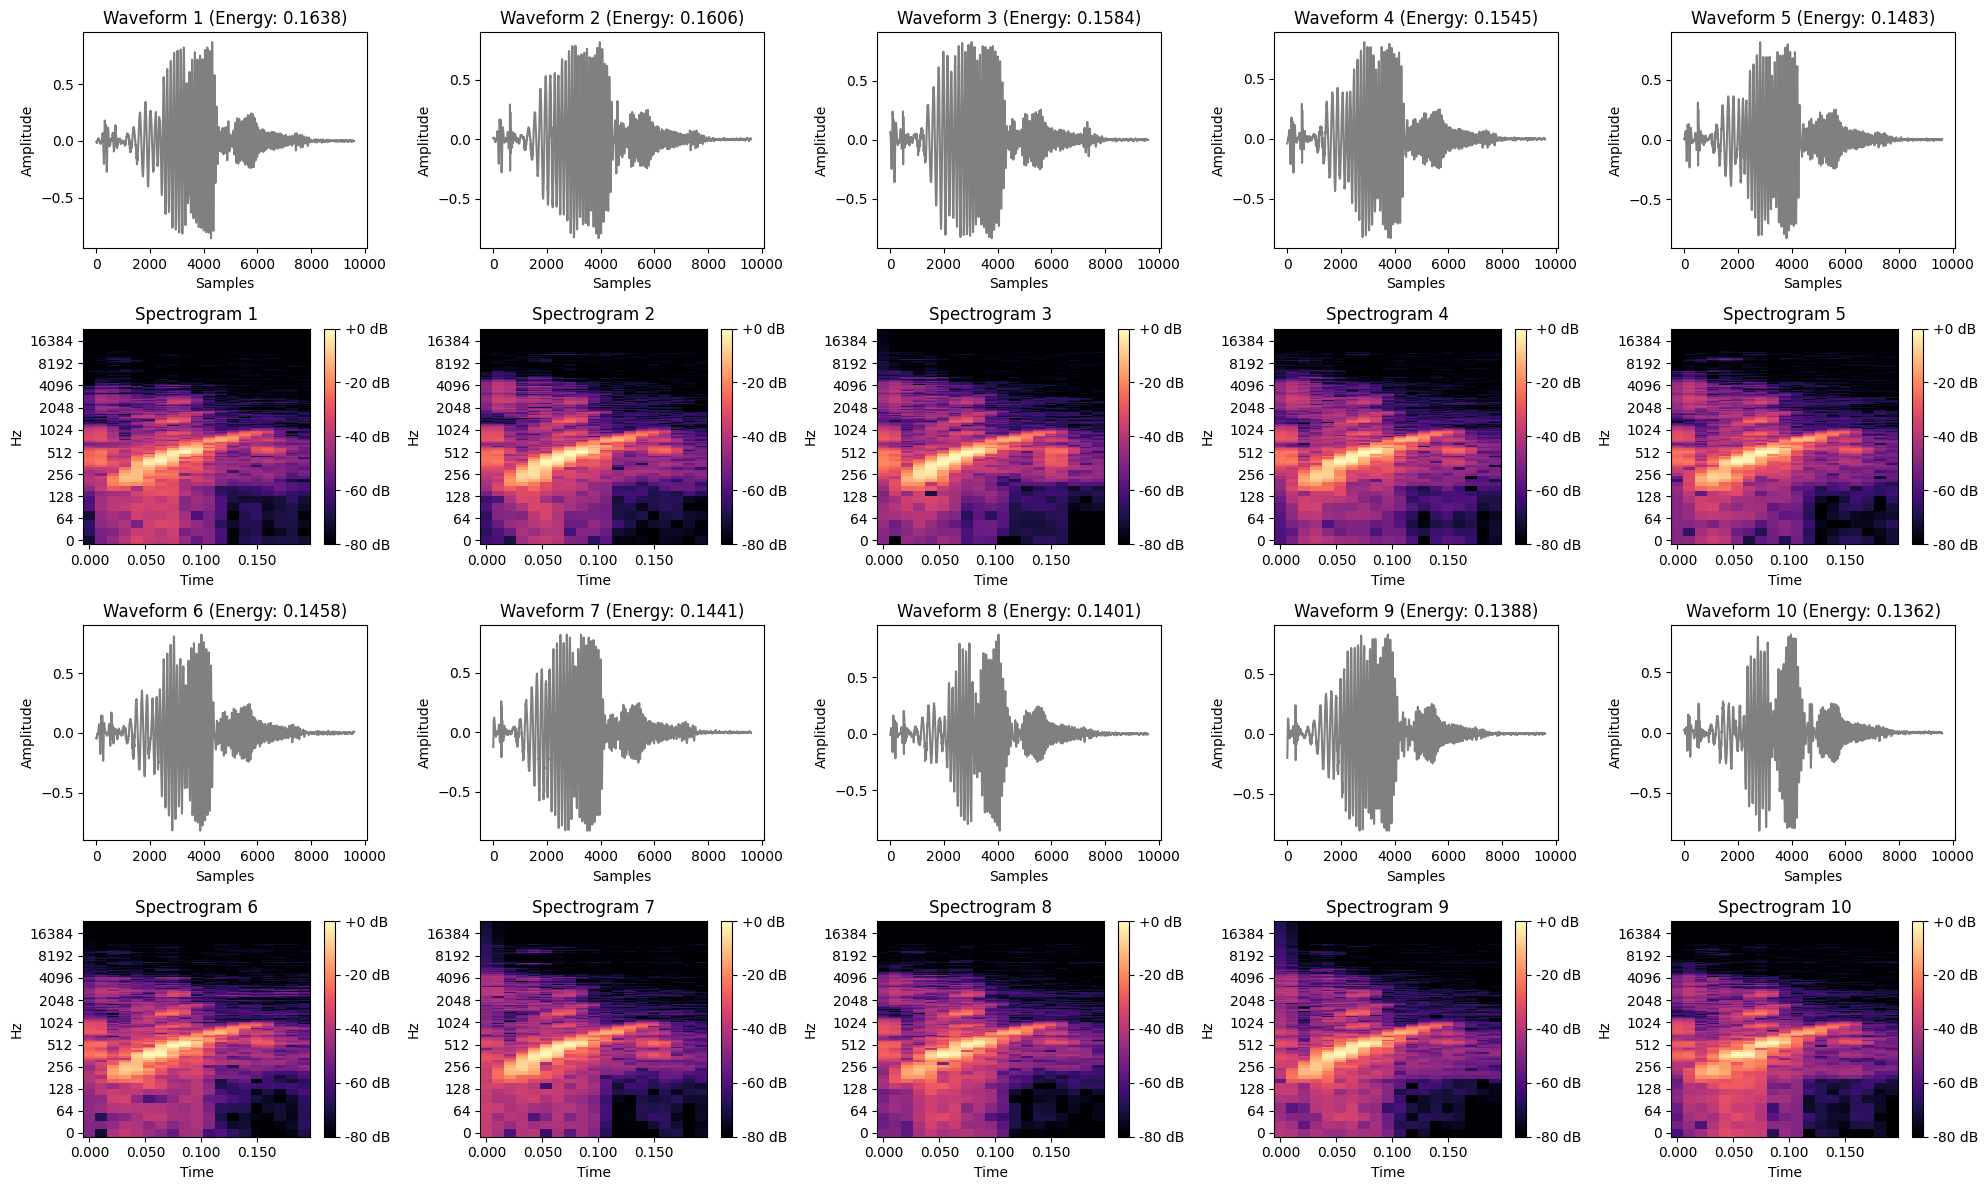

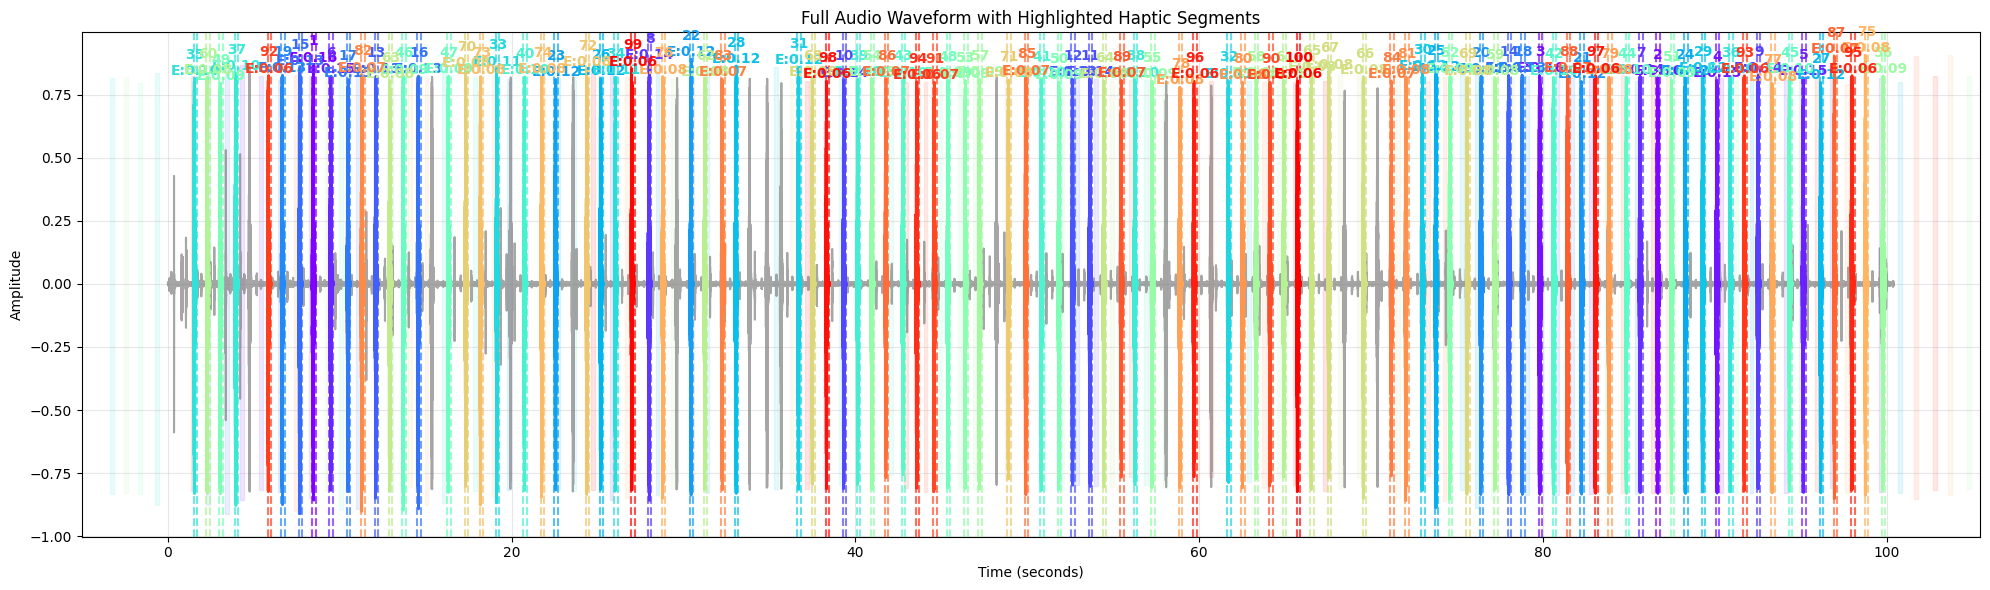

In [5]:
plot_audio_haptic_segments(u1_d)
plot_full_audio_with_segments(u1_d)

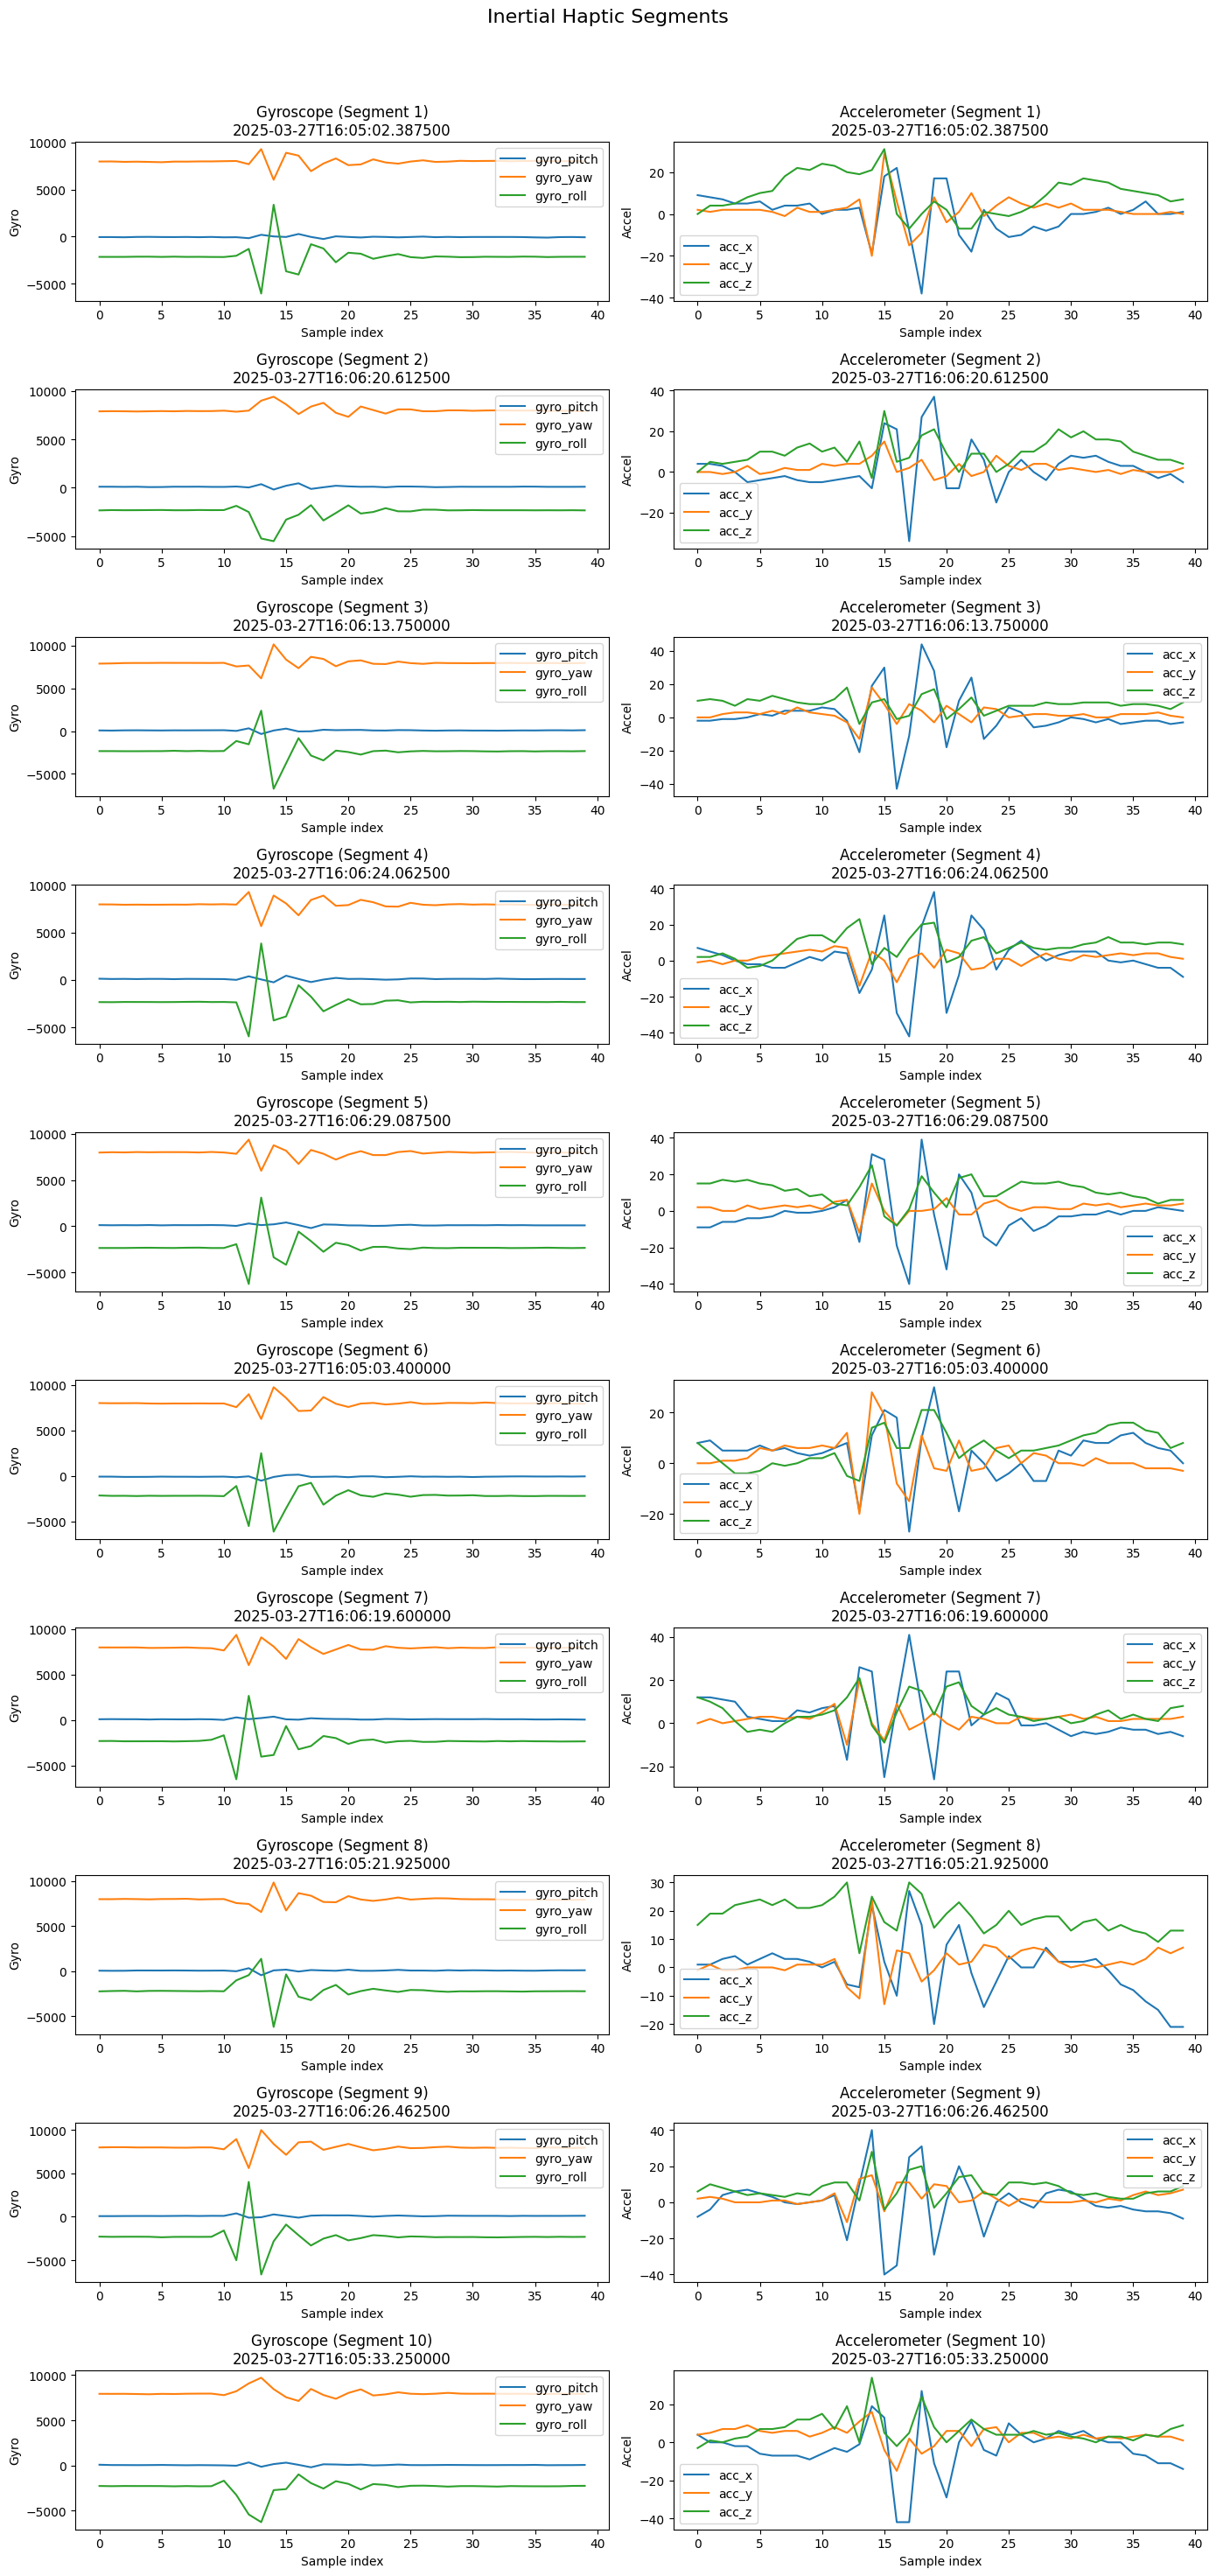

In [6]:
plot_inertial_haptic_sequences_grid(u1_d)